# ICESat-2 and Landsat cloud access and data integration

This notebook ({nb-download}`download <IS2_cloud_data_integration.ipynb>`) builds off of the icepyx [IS2_cloud_data_access.ipynb](https://icepyx.readthedocs.io/en/latest/example_notebooks/IS2_cloud_data_access.html) and [ICESat-2 Hackweek Data Integration 1](https://icesat-2.hackweek.io/tutorials/DataIntegration/dataintegration-1.html) tutorials. It illustrates the use of icepyx for accessing ICESat-2 data currently available through the AWS (Amazon Web Services) us-west2 hub s3 data bucket as well as data integration with Landsat (cloud-optimized geotiff) and ATM (downloaded csv) datasets.

```{admonition} Learning Objectives
**Goals**
- Identify and locate ICESat-2 and Landsat data
- Acquire data from the cloud
- Open data in `pandas` and `xarray` and basic functioning of DataFrames
```

```{admonition} Key Takeaway
By the end of this tutorial, you will be able to visualize Landsat Cloud Optimized Geotiffs with ICESat-2 and ATM data.
```

## Notes
1. ICESat-2 data became publicly available on the cloud on 29 September 2022. Thus, access methods and example workflows are still being developed by NSIDC, and the underlying code in icepyx will need to be updated now that these data (and the associated metadata) are available. We appreciate your patience and contributions (e.g. reporting bugs, sharing your code, etc.) during this transition!
2. This example and the code it describes are part of ongoing development. Current limitations to using these features are described throughout the example, as appropriate.
3. You **MUST** be working within an AWS instance. Otherwise, you will get a permissions error.
4. Authentication is still more steps than we'd like. We're working to address this - let us know if you'd like to join the conversation!

For this tutorial, feel free to run the code along with us as we live code by downsizing the zoom window and splitting your screen (or using two screens). Or you can simply watch the zoom walkthrough. Don't worry if you fall behind on the code. The notebook is standalone and you can easily run the code at your own pace another time to catch anything you missed. 

## Computing environment

We'll be using the following open source Python libraries in this notebook:

In [9]:
# Suppress library deprecation warnings
import logging
logging.captureWarnings(True)

In [10]:
import ipyleaflet
from ipyleaflet import Map, GeoData, LayersControl,Rectangle, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon

import ipywidgets
import datetime
import re

In [ ]:
%matplotlib widget
import pystac_client
import geopandas as gpd
import ast
import pandas as pd
import geoviews as gv
import hvplot.pandas
from ipywidgets import interact
from IPython.display import display, Image
import intake # if you've installed intake-STAC, it will automatically import alongside intake
import xarray as xr
import matplotlib.pyplot as plt
import boto3
import rasterio as rio
from rasterio.session import AWSSession
from rasterio.plot import show
import rioxarray as rxr
from dask.utils import SerializableLock
import os
import fiona
import hvplot.xarray
import numpy as np
from pyproj import Proj, transform

## 1. Identify and acquire the ICESat2 product(s) of interest

### Download ICESat-2 ATL06 data from desired region

We are going to use icepyx to download some ICESat-2 ATL06 data over our region of interest.

In [12]:
import icepyx as ipx

ImportError: cannot import name 'Box' from 'bokeh.models' (/srv/conda/envs/notebook/lib/python3.10/site-packages/bokeh/models/__init__.py)

In [11]:
# Specifying the necessary icepyx parameters
short_name = 'ATL06'
spatial_extent = 'hackweek_kml_jakobshavan.kml' # KML polygon centered on Jakobshavan
date_range = ['2019-04-01', '2019-04-30']
rgts = ['338'] # IS-2 RGT of interest

# # bounding box
# # "producerGranuleId": "ATL03_20191130221008_09930503_004_01.h5",
# short_name = 'ATL03'
# spatial_extent = [-45, 58, -35, 75]
# date_range = ['2019-11-30','2019-11-30']

You may notice that we specified a RGT track. As seen below, a large number of ICESat-2 overpasses occur for Jakobshavan. In the interest of time (and computer memory), we are going to look at only one of these tracks.

In [12]:
# Show image of area of interest (data viz tutorial will get in deeper so don't explain much):
center = [69.2, -50]
zoom = 7

# Open KML file for visualizing
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default
jk = gpd.read_file(spatial_extent)


m = Map(basemap=basemap_to_tiles(basemaps.NASAGIBS.ModisAquaTrueColorCR, '2020-07-18'),center=center,zoom=zoom)
geo_data = GeoData(geo_dataframe = jk)

m.add_layer(geo_data)
m.add_control(LayersControl())
m

Map(center=[69.2, -50], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [13]:
# Setup the Query object
region = ipx.Query(short_name, spatial_extent, date_range, tracks=rgts)

Looks like we have an ICESat-2 track! Let's quickly visualize the data to ensure that there are no clouds.

In [14]:
# Request information from OpenAltimetry
cyclemap, rgtmap = region.visualize_elevation()

rgtmap

AttributeError: 'list' object has no attribute 'minimum_rotated_rectangle'

Looks good! Now it's time to acquire the data.

## Get the granule s3 urls
You must specify `cloud=True` to get the needed s3 urls.
This function returns a list containing the list of the granule IDs and a list of the corresponding urls.

In [15]:
gran_ids = region.avail_granules(ids=True, cloud=True)
gran_ids

[['ATL06_20190420093051_03380303_005_01.h5'],
 ['s3://nsidc-cumulus-prod-protected/ATLAS/ATL06/005/2019/04/20/ATL06_20190420093051_03380303_005_01.h5']]

## Log in to Earthdata and generate an s3 token
You can use icepyx's existing login functionality to generate your s3 data access token, which will be valid for *one* hour.

We currently do not have this set up to automatically renew, but [earthaccess](), which icepyx will soon be adopting for authentication, is working on handling the limits imposed by expiring s3 tokens. If you're interested in working on helping icepyx and NSIDC (and DAACs more broadly) address these challenges, please get in touch or submit a PR. Documentation/example testers are always appreciated (so you don't have to understand the code)!

In [16]:
region.earthdata_login("tsnow03","tsnow@mines.edu", s3token=True)

Earthdata Login password:  ········


In [17]:
credentials = region._s3login_credentials

## Set up your s3 access using your credentials

In [18]:
import s3fs

In [19]:
s3 = s3fs.S3FileSystem(key=credentials['accessKeyId'],
                       secret=credentials['secretAccessKey'],
                       token=credentials['sessionToken'])

## Select an s3 url and access the data
Data read in capabilities for cloud data are coming soon in icepyx (targeted Winter 2022-2023). Stay tuned and we'd love for you to join us and contribute!

**Note: If you get a PermissionDenied Error when trying to read in the data, you may not be sending your request from an AWS hub in us-west2. We're currently working on how to alert users if they will not be able to access ICESat-2 data in the cloud for this reason**

In [20]:
# the first index, [1], gets us into the list of s3 urls
# the second index, [0], gets us the first entry in that list.
s3url = gran_ids[1][0]
# s3url =  's3://nsidc-cumulus-prod-protected/ATLAS/ATL03/004/2019/11/30/ATL03_20191130221008_09930503_004_01.h5'

In [21]:
import h5py

In [22]:
# Open the file
%time f = h5py.File(s3.open(s3url,'rb'),'r')

CPU times: user 52 ms, sys: 50.9 ms, total: 103 ms
Wall time: 645 ms


In [23]:
# View it's attributes
list(f.keys())

['METADATA',
 'ancillary_data',
 'gt1l',
 'gt1r',
 'gt2l',
 'gt2r',
 'gt3l',
 'gt3r',
 'orbit_info',
 'quality_assessment']

Reading the file with h5py allows us to open the entire file, but is not super intuitive for later analysis. Let's use h5py with pandas to open the data into DataFrames in a way that is more convenient for our analyses.

In [24]:
# Load the ICESat-2 data. We will just look at the central beams (GT2R/L)
# is2_file = 'processed_ATL06_20190420093051_03380303_005_01_full.h5'
with h5py.File(s3.open(s3url,'rb'), 'r') as f:
    is2_gt2r = pd.DataFrame(data={'lat': f['gt2r/land_ice_segments/latitude'][:],
                                  'lon': f['gt2r/land_ice_segments/longitude'][:],
                                  'elev': f['gt2r/land_ice_segments/h_li'][:]})
    is2_gt2l = pd.DataFrame(data={'lat': f['gt2l/land_ice_segments/latitude'][:],
                                  'lon': f['gt2l/land_ice_segments/longitude'][:],
                                  'elev': f['gt2l/land_ice_segments/h_li'][:]})
    
is2_gt2r.head()

,lat,lon,elev
0,60.576127,-47.336870,1.026412e+02
1,60.576487,-47.336899,3.402823e+38
2,60.576666,-47.336935,3.402823e+38
3,60.577023,-47.337009,3.402823e+38
4,60.577202,-47.337046,3.402823e+38


We opened this data into a `pandas` DataFrame, which is a handy tool for Earth data exploration and analysis. The column names derive automatically from the first row of the csv and each row corresponds to an ATM measurement.

For a tutorial on how to use `pandas` on this data, check out the [ICESat-2 Hackweek Data Integration I tutorial](https://icesat-2.hackweek.io/tutorials/DataIntegration/dataintegration-1.html). You can learn more about `pandas` from [this cookbook](https://pandas.pydata.org/docs/user_guide/index.html#user-guide).

## 2. Acquire non-cloud data and open:  ATM data access

Now we will show ATM (non-AWS) and Landsat (AWS)

Why did we choose April 2019 and RGT 338? In Spring 2019, an airborne campaign called Operation IceBridge was flown across Jakobshavan as validation for ICESat-2. Onboard was the Airborne Topographic Mapper, a lidar that works at both 532 nm (like ICESat-2) and 1064 nm (near-infrared). More information about Operation IceBridge and ATM may be found here: https://nsidc.org/data/icebridge

Here, we are going to try and co-register ATM spot measurements with ICESat-2. Because both data sets are rather large, this can be computationally expensive, so we will only consider one flight track with the ATM 532 nm beam.

Operation IceBridge data is not available on the cloud, so this data was downloaded directly from NSIDC. If you are interested in using IceBridge data, NSIDC has a useful data portal here: https://nsidc.org/icebridge/portal/map

### Co-register ICESat-2 with ATM data

In [54]:
# Load the ATM data into a DataFrame
atm_file = 'ILATM2_20190506_151600_smooth_nadir3seg_50pt.csv'
atm_l2 = pd.read_csv(atm_file)

atm_l2.head()

,UTC_Seconds_Of_Day,Latitude(deg),Longitude(deg),WGS84_Ellipsoid_Height(m),South-to-North_Slope,West-to-East_Slope,RMS_Fit(cm),Number_Of_ATM_Measurments_Used,Number_Of_ATM_Measurements_Removed,Distance_Of_Block_To_The_Right_Of_Aircraft(m),Track_Identifier
0,54969.50,69.262002,310.351764,490.3974,0.077354,-0.069179,589.57,3723,5,78,1
1,54969.50,69.262065,310.353395,500.2330,-0.048777,0.006024,434.12,2185,21,14,2
2,54969.50,69.262128,310.355026,500.3090,0.068798,0.077559,777.80,3640,8,-51,3
3,54969.50,69.262079,310.353741,498.9152,-0.085600,-0.111001,472.64,2818,15,0,0
4,54969.75,69.261648,310.351873,487.1317,0.108085,-0.078827,520.83,3753,33,78,1


The ATM L2 file contains plenty of information, including surface height estimates and slope of the local topography. It also contains a track identifier - ATM takes measurements from multiple parts of the aircraft, namely starboard, port, and nadir. To keep things simple, we will filter the DataFrame to only look at the nadir track (Track_Identifier = 0).

In [55]:
atm_l2 = atm_l2[atm_l2['Track_Identifier']==0]

# Change the longitudes to be consistent with ICESat-2
atm_l2['Longitude(deg)'] -= 360

print(atm_l2.size)

2123


Let's take a quick look at where ATM is relative to ICESat-2...

In [56]:
# Subset the ICESat-2 data to the ATM latitudes
is2_gt2r = is2_gt2r[(is2_gt2r['lat']<atm_l2['Latitude(deg)'].max()) & (is2_gt2r['lat']>atm_l2['Latitude(deg)'].min())]
is2_gt2l = is2_gt2l[(is2_gt2l['lat']<atm_l2['Latitude(deg)'].max()) & (is2_gt2l['lat']>atm_l2['Latitude(deg)'].min())]


# Set up a map with the flight tracks as overlays
from ipyleaflet import Map, basemaps, basemap_to_tiles, Polyline

m = Map(
    basemap=basemap_to_tiles(basemaps.Esri.WorldImagery),
    center=(69.25, 310.35-360),
    zoom=10
)

gt2r_line = Polyline(
    locations=[
        [is2_gt2r['lat'].min(), is2_gt2r['lon'].max()],
        [is2_gt2r['lat'].max(), is2_gt2r['lon'].min()]
    ],
    color="green" ,
    fill=False
)
m.add_layer(gt2r_line)

gt2l_line = Polyline(
    locations=[
        [is2_gt2l['lat'].min(), is2_gt2l['lon'].max()],
        [is2_gt2l['lat'].max(), is2_gt2l['lon'].min()]
    ],
    color="green" ,
    fill=False
)
m.add_layer(gt2l_line)

atm_line = Polyline(
    locations=[
        [atm_l2['Latitude(deg)'].min(), atm_l2['Longitude(deg)'].max()],
        [atm_l2['Latitude(deg)'].max(), atm_l2['Longitude(deg)'].min()]
    ],
    color="orange" ,
    fill=False
)
m.add_layer(atm_line)

m

Map(center=[69.25, -49.64999999999998], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

Looks like ATM aligns very closely with the left beam (GT2L), so hopefully the two beams will agree. The terrain over this region is quite rough, so we may expect some differences between ATM and GT2R. ICESat-2 also flew over Jakobshavan 16 days before ATM, so there might be slight differences due to ice movement.

We have looked at how we can quickly access ICESat-2 and airborne lidar data, and process them using `pandas`. 

## 3.  Search and open (Landsat) raster imagery from the cloud

Let's now talk about a cloud-optimized approach that requires no downloading to search and access only the subsets of the data we want. Cloud-optimized formats (e.g., [COG](https://www.cogeo.org/), [zarr](https://zarr.readthedocs.io/en/latest/index.html), [parquet](https://parquet.apache.org/)) make reading data two orders of magnitude faster than non-optimized formats.

### Cloud optimized approaches
* Organize data as an aggregation of small, independently retrievable objects (e.g., zarr, HDF2, Geotiff in the Cloud)
* Allow access to pieces of large objects (e.g., Cloud-Optimized GeoTIFF3, OPeNDAP4 in the Cloud)

We will be working with Cloud Optimized GeoTIFF (COG). A COG is a GeoTIFF file with an internal organization that enables more efficient workflows by allowing us to ask for just the parts of a file we need, instead of having to open the entire image or data set (see more at https://www.cogeo.org/).

Example url for accessing a band in the cloud from an S3 bucket:\
s3://usgs-landsat/collection02/level-2/standard/oli-tirs/2020/202/025/LC08_L1TP_202025_20190420_20190507_01_T1/LC08_L1TP_202025_20190420_20190507_01_T1_B4.TIF

Here is the [User Manual](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-2032-Landsat-Commercial-Cloud-Direct-Access-Users-Guide-v2.pdf.pdf) for more information about accessing Landsat S3.

### Search for Landsat imagery

To explore and access COG's easily we will use a [SpatioTemporal Asset Catalog (STAC)](https://github.com/radiantearth/stac-spec). The STAC provides a common metadata format to make it easier to index and querry S3 buckets for geospatial data.

In [57]:
# Sets up AWS credentials for acquiring images through dask/xarray
os.environ["AWS_REQUEST_PAYER"] = "requester"

# Sets up proper AWS credentials for acquiring data through rasterio
aws_session = AWSSession(boto3.Session(), requester_pays=True)

Extract geometry bounds are extracted from the ICESat-2 KML file used above so that we can perform the Landsat spatial search.

In [58]:
# Extract geometry bounds
geom = jk.geometry[0]
print(geom.bounds)

(-51.3229009069365, 68.84029223511094, -48.20366423696812, 69.61656633135274)


We will search for imagery in STAC catalog using the [pystac_client](https://pystac-client.readthedocs.io/en/stable/usage.html) search tool.

In [59]:
# Search STAC API for Landsat images based on a bounding box, date and other metadata if desired

bbox = (geom.bounds[0], geom.bounds[1], geom.bounds[2], geom.bounds[3]) #(west, south, east, north) 

timeRange = '2019-05-06/2019-05-07'
url = 'https://landsatlook.usgs.gov/stac-server'
collection = 'landsat-c2l1'
    
api = pystac_client.Client.open(url)

items = api.search(
            bbox = bbox,
            datetime = timeRange,
            limit = 400,
            collections=collection
        ).get_all_items()
    
print(f'{len(items)} items')

# Write a json file that records our search output
gjson_outfile = f'/home/jovyan/Landsat.geojson'
items.save_object(gjson_outfile)

2 items


We can include property searches, such as path, row, cloud-cover, as well with the `properties` flag.

We are given a satsearch collection of items (images)

In [60]:
items

ID: LC08_L1TP_008012_20190507_20200829_02_T1
"Bounding Box: [-52.450348972917006, 67.13075970832166, -46.38012875444901, 69.41548599740054]"
Datetime: 2019-05-07 14:54:18.865855+00:00
datetime: 2019-05-07T14:54:18.865855Z
eo:cloud_cover: 0.18
view:sun_azimuth: 173.85264541
view:sun_elevation: 38.46360597
platform: LANDSAT_8
"instruments: ['OLI', 'TIRS']"
view:off_nadir: 0
landsat:cloud_cover_land: 0


Load the geojson file into geopandas and inspect the items we want to collect

In [61]:
# Load the geojson file
gf = gpd.read_file(gjson_outfile)
gf.head(2)

,id,datetime,eo:cloud_cover,view:sun_azimuth,view:sun_elevation,platform,view:off_nadir,landsat:cloud_cover_land,landsat:wrs_type,landsat:wrs_path,...,landsat:correction,accuracy:geometric_x_bias,accuracy:geometric_y_bias,accuracy:geometric_x_stddev,accuracy:geometric_y_stddev,accuracy:geometric_rmse,proj:epsg,created,updated,geometry
0,LC08_L1TP_008012_20190507_20200829_02_T1,2019-05-07 14:54:18.866000+00:00,0.18,173.852645,38.463606,LANDSAT_8,0,0.0,2,008,...,L1TP,0,0,3.431,3.144,4.654,32622,2022-06-28 20:15:52.467000+00:00,2022-06-28 20:15:52.467000+00:00,"POLYGON ((-50.65493 69.41549, -52.45035 67.796..."
1,LC08_L1TP_008011_20190507_20200828_02_T1,2019-05-07 14:53:54.971000+00:00,10.18,175.877442,37.193127,LANDSAT_8,0,10.3,2,008,...,L1TP,0,0,3.409,4.025,5.275,32623,2022-06-28 23:23:03.741000+00:00,2022-06-28 23:23:03.741000+00:00,"POLYGON ((-48.95109 70.75210, -50.97098 69.148..."


In [62]:
# Plot search area of interest and frames on a map using Holoviz Libraries (more on these later)
cols = gf.loc[:,('id','landsat:wrs_path','landsat:wrs_row','geometry')]
footprints = cols.hvplot(geo=True, line_color='k', hover_cols=['landsat:wrs_path','landsat:wrs_row'], alpha=0.3, title='Landsat 8 T1',tiles='ESRI')
tiles = gv.tile_sources.CartoEco.options(width=700, height=500) 
labels = gv.tile_sources.StamenLabels.options(level='annotation')
tiles * footprints * labels

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]   (landsat:wrs_path,landsat:wrs_row)
   .WMTS.II    :WMTS   [Longitude,Latitude]

### Intake all scenes using the intake-STAC library
`Intake-STAC` facilitates discovering, exploring, and loading spatio-temporal datasets by providing Intake Drivers for STAC catalogs. This provides a simple toolkit for working with STAC catalogs and for loading STAC assets as `xarray` objects.

In [63]:
catalog = intake.open_stac_item_collection(items)
list(catalog)

['LC08_L1TP_008012_20190507_20200829_02_T1',
 'LC08_L1TP_008011_20190507_20200828_02_T1']

Let's explore the metadata and keys for the first scene

In [64]:
sceneids = list(catalog)
item3 = catalog[sceneids[1]]
# item3.metadata
for keys in item3.keys():
    print (keys)

thumbnail
reduced_resolution_browse
index
MTL.json
coastal
blue
green
red
nir08
swir16
swir22
pan
cirrus
lwir11
lwir12
qa_pixel
qa_radsat
ANG.txt
VAA
VZA
SAA
SZA
MTL.txt
MTL.xml


We can explore the metadata for any of these:

In [65]:
item3['blue'].metadata

{'href': 'https://landsatlook.usgs.gov/data/collection02/level-1/standard/oli-tirs/2019/008/011/LC08_L1TP_008011_20190507_20200828_02_T1/LC08_L1TP_008011_20190507_20200828_02_T1_B2.TIF',
 'type': 'image/vnd.stac.geotiff; cloud-optimized=true',
 'title': 'Blue Band (B2)',
 'description': 'Collection 2 Level-1 Blue Band (B2) Top of Atmosphere Radiance',
 'eo:bands': [{'name': 'B2',
   'common_name': 'blue',
   'gsd': 30,
   'center_wavelength': 0.48}],
 'alternate': {'s3': {'storage:platform': 'AWS',
   'storage:requester_pays': True,
   'href': 's3://usgs-landsat/collection02/level-1/standard/oli-tirs/2019/008/011/LC08_L1TP_008011_20190507_20200828_02_T1/LC08_L1TP_008011_20190507_20200828_02_T1_B2.TIF'}},
 'file:checksum': '1340f0a602019909fbb3e6bd909443ef7f9adfe7efabc86586f6e5f85e941aab30f03adbde671e000852b535ce627d864c1e6c3b33011a907b9a67fa1b7e595d9f42',
 'roles': ['data'],
 'plots': {'geotiff': {'kind': 'image',
   'x': 'x',
   'y': 'y',
   'frame_width': 500,
   'data_aspect': 1,
  

In [66]:
items[1]

ID: LC08_L1TP_008011_20190507_20200828_02_T1
"Bounding Box: [-50.97097968875044, 68.44897504333066, -44.463480823181705, 70.75209635973746]"
Datetime: 2019-05-07 14:53:54.970580+00:00
datetime: 2019-05-07T14:53:54.970580Z
eo:cloud_cover: 10.18
view:sun_azimuth: 175.87744165
view:sun_elevation: 37.19312658
platform: LANDSAT_8
"instruments: ['OLI', 'TIRS']"
view:off_nadir: 0
landsat:cloud_cover_land: 10.3


In [67]:
# This is the url needed to grab data from the S3 bucket using the intake-STAC catalog
item3.blue.metadata['alternate']['s3']['href'] # must use item asset name (blue)

's3://usgs-landsat/collection02/level-1/standard/oli-tirs/2019/008/011/LC08_L1TP_008011_20190507_20200828_02_T1/LC08_L1TP_008011_20190507_20200828_02_T1_B2.TIF'

### Open and visualize each image using RasterIO 

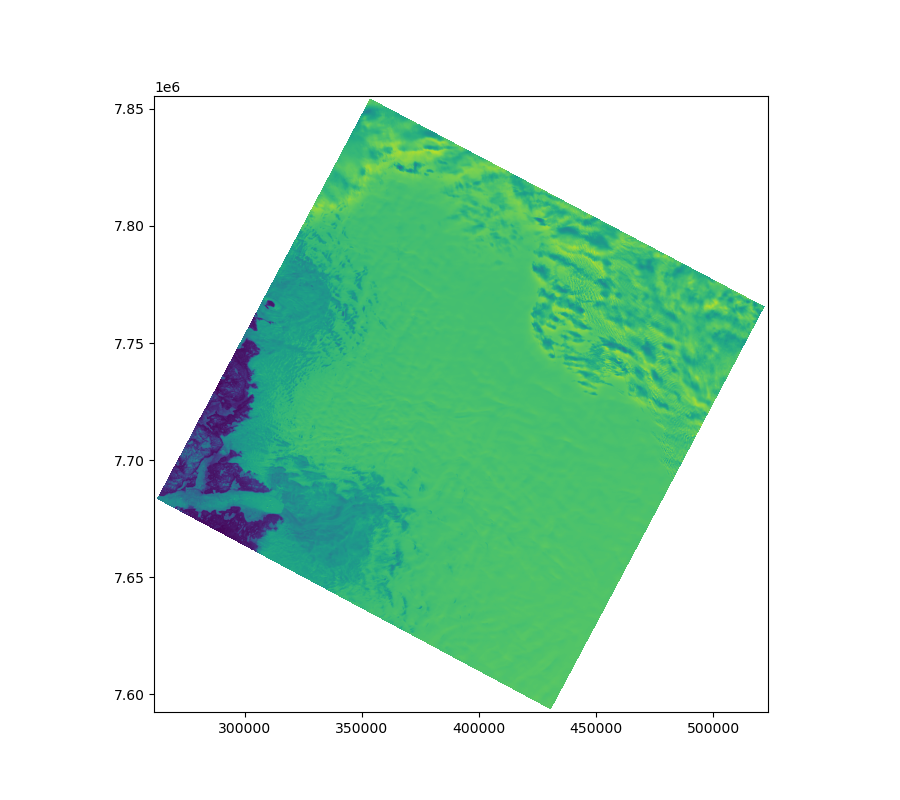

In [68]:
import rasterio as rio

# Retrieve first scene using rio
item_url = item3.blue.metadata['alternate']['s3']['href']

# Read and plot with grid coordinates 
with rio.Env(aws_session):
    with rio.open(item_url) as src:
        fig, ax = plt.subplots(figsize=(9,8))
        
        # To plot
        show(src,1)
        
        # To open data into a numpy array
        profile = src.profile
        arr = src.read(1)

We can open directly into `xarray` using `rasterIO`...

### Manipulating data in Xarray

`Pandas` and `xarray` have very similar structures and ways of manipulating data, but `pandas` excels with 2-D data and `xarray` is ideal for higher dimension data. `Xarray` introduces labels in the form of dimensions, coordinates and attributes on top of Pandas-like DataFrames.

`Xarray` has 2 fundamental data structures:

* `DataArray`, which holds single multi-dimensional variables and its coordinates
* `Dataset`, which holds multiple variables that potentially share the same coordinates

<img src="https://xarray-contrib.github.io/xarray-tutorial/_images/xarray-data-structures.png" width="800px">


We will only scratch the surface here on what `xarray` can do. To learn more, there are great `xarray` tutorials here: https://xarray-contrib.github.io/xarray-tutorial/online-tutorial-series/01_xarray_fundamentals.html

#### RasterIO and RioXarray

We can use `rasterIO` to easily open into an `xarray` `DataArray`:

In [69]:
rastxr = xr.open_dataarray(item_url,engine='rasterio')
rastxr

<xarray.DataArray 'band_data' (band: 1, y: 8771, x: 8741)>
[76667311 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.613e+05 2.613e+05 ... 5.235e+05 5.235e+05
  * y            (y) float64 7.856e+06 7.855e+06 ... 7.592e+06 7.592e+06
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Point

Or a `DataSet`:

In [70]:
rastxr = xr.open_dataset(item_url,engine='rasterio')
rastxr

<xarray.Dataset>
Dimensions:      (band: 1, x: 8741, y: 8771)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.613e+05 2.613e+05 ... 5.235e+05 5.235e+05
  * y            (y) float64 7.856e+06 7.855e+06 ... 7.592e+06 7.592e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

We can open using `rioxarray`, which integrates `rasterIO` and `xarray` and is the most efficient way of opening using `rasterIO`:

In [71]:
import rioxarray as rxr

rastrxr = rxr.open_rasterio(item_url)
rastrxr

<xarray.DataArray (band: 1, y: 8771, x: 8741)>
[76667311 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.613e+05 2.613e+05 ... 5.235e+05 5.235e+05
  * y            (y) float64 7.856e+06 7.855e+06 ... 7.592e+06 7.592e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

We can see `Attributes` have been added to the `xarray` using the same url.

Beyond what `xarray` and `rasterIO` provide, `rioxarray` has these added benefits (plus others):
* Supports multidimensional datasets such as netCDF
* Loads in the CRS, transform, and nodata metadata in standard CF & GDAL locations
* Supports masking and scaling data
* Loads raster metadata into the attributes

For more info: https://corteva.github.io/rioxarray/stable/index.html

#### Dask

Another convenient means for opening a lot of raster data into `xarray` is using `dask`. `Xarray` integrates with Dask to support parallel computations and streaming computation on datasets that don’t fit into memory. So this is perfect when you want to process a lot of data. 

`Dask` divides arrays into many small pieces, called chunks, each of which is presumed to be small enough to fit into memory.

Unlike `NumPy`, which has eager evaluation, operations on `dask` arrays are lazy. Operations queue up a series of tasks mapped over blocks, and no computation is performed until you actually ask values to be computed (e.g., to print results to your screen or write to disk). At that point, data is loaded into memory and computation proceeds in a streaming fashion, block-by-block.

More on Dask in the Cloud Computing Tools tutorial.

To expand our `xarray` toolbox for working with larger data sets that we don't necessarily want entirely in memory, we will start by reading in 3 bands of a Landsat scene to `xarray` using `dask`.

In [72]:
sceneid = catalog[sceneids[0]]
print (sceneid.name)

band_names = ['red','green','blue']

bands = []

# Construct xarray for scene
for band_name in band_names:
    # Specify chunk size (x,y), Landsat COG is natively in 512 chunks so is best to use this or a multiple
    band = sceneid[band_name](chunks=dict(band=1, x=2048, y=2048),urlpath=sceneid[band_name].metadata['alternate']['s3']['href']).to_dask()
    band['band'] = [band_name]
    bands.append(band)
scene = xr.concat(bands, dim='band')
scene

LC08_L1TP_008012_20190507_20200829_02_T1


<xarray.DataArray (band: 3, y: 8491, x: 8431)>
dask.array<concatenate, shape=(3, 8491, 8431), dtype=uint16, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) <U5 'red' 'green' 'blue'
  * y        (y) float64 7.702e+06 7.702e+06 7.702e+06 ... 7.447e+06 7.447e+06
  * x        (x) float64 4.371e+05 4.371e+05 4.372e+05 ... 6.9e+05 6.9e+05
Attributes:
    transform:      (30.0, 0.0, 437085.0, 0.0, -30.0, 7701615.0)
    crs:            +init=epsg:32622
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

Typically, it’s best to align [dask chunks](https://docs.dask.org/en/latest/array-best-practices.html) with the way image chunks (typically called “tiles”) are stored on disk or cloud storage buckets. The landsat data is stored on AWS S3 in a tiled Geotiff format where tiles are 512x512, so we should pick some multiple of that, and typically aim for chunk sizes of ~100Mb (although this is subjective).

In a way that is similar to `pandas`, we can explore variables easily in `xarray`. We will first work with coordinates (equivalent to indices in `pandas`). Here `x` might often be the longitude (it can be renamed to this actually):

In [73]:
scene.x

<xarray.DataArray 'x' (x: 8431)>
array([437100., 437130., 437160., ..., 689940., 689970., 690000.])
Coordinates:
  * x        (x) float64 4.371e+05 4.371e+05 4.372e+05 ... 6.9e+05 6.9e+05

We can also keep track of arbitrary metadata (called attributes) in the form of a Python dictionary: 

In [74]:
scene.attrs

{'transform': (30.0, 0.0, 437085.0, 0.0, -30.0, 7701615.0),
 'crs': '+init=epsg:32622',
 'res': (30.0, 30.0),
 'is_tiled': 1,
 'nodatavals': (0.0,),
 'scales': (1.0,),
 'offsets': (0.0,),
 'AREA_OR_POINT': 'Point'}

In [75]:
scene.crs

'+init=epsg:32622'

We can apply operations over dimensions by name. Here, if we want to slice the data to only have the blue band:

In [76]:
scene.sel(band='blue')

<xarray.DataArray (y: 8491, x: 8431)>
dask.array<getitem, shape=(8491, 8431), dtype=uint16, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    band     <U5 'blue'
  * y        (y) float64 7.702e+06 7.702e+06 7.702e+06 ... 7.447e+06 7.447e+06
  * x        (x) float64 4.371e+05 4.371e+05 4.372e+05 ... 6.9e+05 6.9e+05
Attributes:
    transform:      (30.0, 0.0, 437085.0, 0.0, -30.0, 7701615.0)
    crs:            +init=epsg:32622
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

Notice that instead of `loc` (from `pandas`) we are using `sel`, but they function synonymously.

Mathematical operations (e.g., x - y) vectorize across multiple dimensions (array broadcasting) based on dimension names. Let's determine the mean reflectance for the blue band:

In [77]:
scene.sel(band='blue').mean()#.values 

<xarray.DataArray ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    band     <U5 'blue'

And you can easily use the split-apply-combine paradigm with groupby, which we won't show here.

### Advanced multi-dimensional read-ins, manipulation and visualization

Now let's open all the bands and multiple days together into an `xarray`. This will be a more complex `xarray` with an extra `'time'` dimension. We have two image in the catalog we can include together.

In [78]:
sceneids = list(catalog)
sceneids

['LC08_L1TP_008012_20190507_20200829_02_T1',
 'LC08_L1TP_008011_20190507_20200828_02_T1']

Let's create the time variable first for the `xarray` time dimension. This finds the desired scene IDs in the `geopandas` dataframe we have above and extracts their 'datetime' information. These datetimes get recorded into an `xarray` variable object for 'time'.

In [79]:
# Create time variable for time dim
time_var = xr.Variable('time',gf.loc[gf.id.isin(sceneids)]['datetime'])
time_var

<xarray.Variable (time: 2)>
array(['2019-05-07T14:54:18.866000000', '2019-05-07T14:53:54.971000000'],
      dtype='datetime64[ns]')

Now we will search and collect band names for grabbing each desired band. We will just grab the bands that have 30 m pixels. This provides an example of how you can search data in the STAC catalog.

In [80]:
band_names = []

# Get band names for the bands with 30 m resolution from the second scene in our sceneids
sceneid = catalog[sceneids[1]]
for k in sceneid.keys():
    M = getattr(sceneid, k).metadata
    if 'eo:bands' in M:
        resol = M['eo:bands'][0]['gsd']
        print(k, resol)
        if resol == 30: 
            band_names.append(k)
            
# Add qa band
band_names.append('qa_pixel')

coastal 30
blue 30
green 30
red 30
nir08 30
swir16 30
swir22 30
pan 15
cirrus 30
lwir11 100
lwir12 100


And now open all of it...

In [81]:
# Import to xarray
# In xarray dataframe nans are in locations where concat of multiple scenes has expanded the grid (i.e. different path/rows).
scenes = []

for sceneid in sceneids:
    sceneid = catalog[sceneid]
    print (sceneid.name)

    bands = []

    # Construct xarray for scene, open each band, append and concatenate together to create a scene, 
    # then append and concatenate each scene to create the full dataframe 
    for band_name in band_names:
        band = sceneid[band_name](chunks=dict(band=1, x=2048, y=2048),urlpath=sceneid[band_name].metadata['alternate']['s3']['href']).to_dask()
        band['band'] = [band_name]
        bands.append(band)
    scene = xr.concat(bands, dim='band')
    scenes.append(scene)

# Concatenate scenes with time variable
ls_scenes = xr.concat(scenes, dim=time_var)

ls_scenes

LC08_L1TP_008012_20190507_20200829_02_T1
LC08_L1TP_008011_20190507_20200828_02_T1


,Array,Chunk
Bytes,26.11 GiB,32.00 MiB
Shape,"(2, 9, 13621, 14291)","(1, 1, 2048, 2048)"
Count,67 Graph Layers,1458 Chunks
Type,float64,numpy.ndarray


We now have 2 Landsat scenes with all of the bands we are interested in stored in an `xarray`, but you can imagine that this exact code can scale to years worth of data and bands.

From here, we easily subset one image at a time or the entire `xarray`:

In [82]:
sbands = ['blue', 'nir08', 'swir16']

# Select the first datetime
t = ls_scenes.time.values[1]
print (t)

# Upper left and lower right coordinates for subsetting to Jakobshavn area
ulx = 300000
uly = 7695000
lrx = 330000
lry = 7670000

# Subset xarray to specific time, bands, and x/y locations
image = ls_scenes.sel(time=t,band=sbands,y=slice(lry,uly),x=slice(ulx,lrx))

2019-05-07T14:53:54.971000000


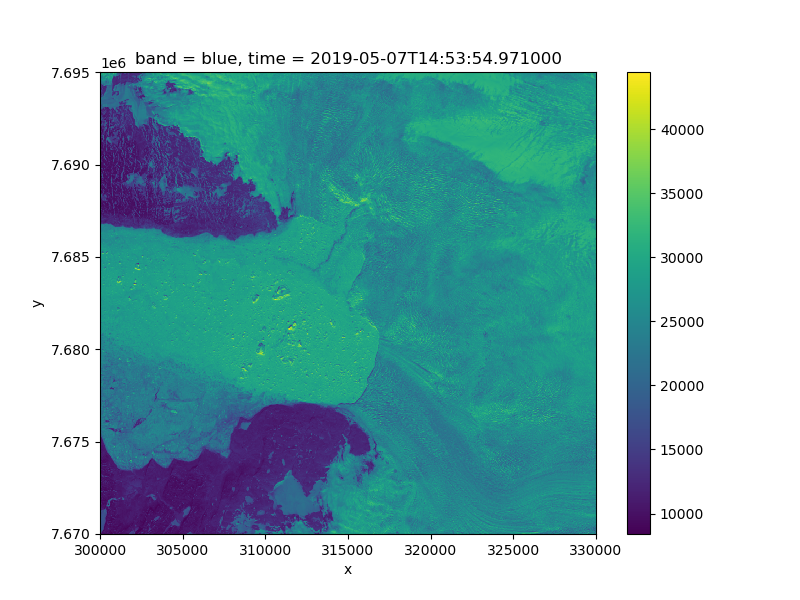

In [83]:
# Plot only the blue band
fig, ax = plt.subplots(figsize=(8,6))
image.sel(band='blue').plot()

Since this data is in UTM 22N, we can reproject to the standard lat/lon coordinate system ([WGS-84](https://epsg.io/4326)) and map with the ICESat-2 and ATM lines.

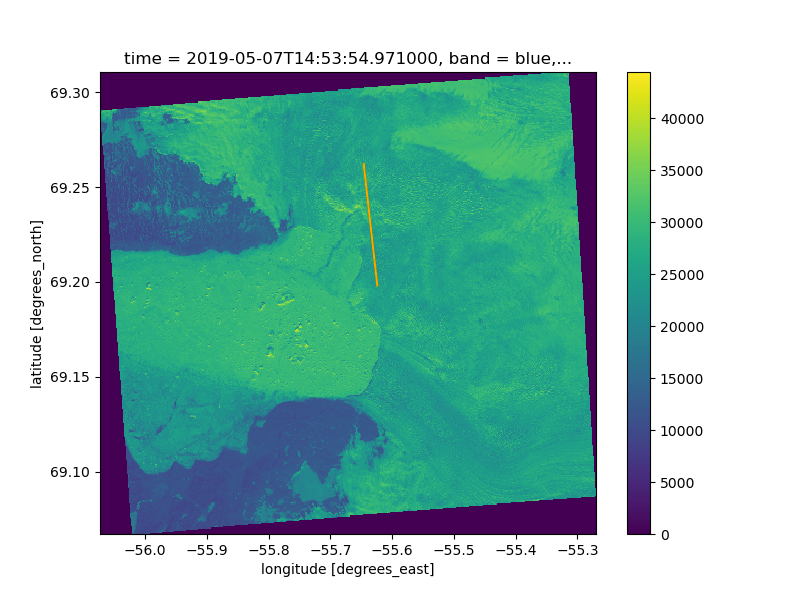

In [84]:
image = image.rio.reproject(4326)

ISlats = [is2_gt2r['lat'].min(), is2_gt2r['lat'].max()]
# ISlons = (is2_gt2r['lon'].max(), is2_gt2r['lon'].min())
ISlons = [-55.624,-55.646]

ATMlats = [atm_l2['Latitude(deg)'].min(), atm_l2['Latitude(deg)'].max()]
# ATMlons = [atm_l2['Longitude(deg)'].max(), atm_l2['Longitude(deg)'].min()]
ATMlons = [-55.624,-55.646]

fig, ax = plt.subplots(figsize=(8,6))
image.sel(band='blue').plot()
plt.plot(ISlons,ISlats,color = 'green')
plt.plot(ATMlons,ATMlats,color = 'orange')

The reprojection to WGS-84 calculated the longitudes to be 6 degrees off, so we shifted the IS2 and ATM data for ease of visualization. This issue only seems to arise with reprojections from some UTM projections and should not be an issue with most data.

## 4. Summary

Congratulations! You've completed the tutorial. In this tutorial you have gained the skills to: 
* Search for both optimized and non-optimized cloud data
* Open data into `pandas` and `xarray` dataframes/arrays, and 
* Manipulate, visualize, and explore the data

We have concluded by mapping the three data sets together. 

#### Credits
* notebook by: Jessica Scheick, Tasha Snow, Zach Fair, Ian Joughin
* source material: [is2-nsidc-cloud.py](https://gist.github.com/bradlipovsky/80ab6a7aff3d3524b9616a9fc176065e#file-is2-nsidc-cloud-py-L28) by Brad Lipovsky